In [1]:
# Install Kaggle
!pip install -q kaggle

In [2]:
# Download Flowers Dataset
import kagglehub

path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-recognition


In [3]:
import torch

def get_default_device():
    """Returns the default device to use for computations."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [4]:
# Defining configuration classes that will hold the hyperparameters for loading the dataset, creating log directories, and training the model

import os
from dataclasses import dataclass

@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "Flowers"

    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"


@dataclass
class TrainingConfig:
    TIMESTEPS = 1000  # Define number of diffusion timesteps (1000)
    IMG_SHAPE = (3, 32, 32)
    NUM_EPOCHS = 20
    BATCH_SIZE = 32
    LR = 1e-4
    NUM_WORKERS = 2

In [5]:
# Creating PyTorch Dataset Class Object

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

# Returns the dataset class object that will be passed to the Dataloader

def get_dataset(dataset_name='Flowers'):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((32, 32),
                                          interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                          antialias=True),
            torchvision.transforms.RandomHorizontalFlip(),
            # torchvision.transforms.Normalize(MEAN, STD),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ]
    )

    if dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root=path, transform=transforms)

    return dataset

In [6]:
# This function is used for inverting the transforms applied during the loading step and reverting the image to the range [0.0, 255.0].

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [7]:
# Function to return a Dataloader object for the chosen dataset.
from torch.utils.data import DataLoader
import torch

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) # yield the batch after moving it to the device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data] # if it's a list or tuple, recursively move each element to the device
    return data.to(device, non_blocking=True) if isinstance(data, torch.Tensor) else data # if it's a tensor, move it to the device asynchronously

def get_dataloader(dataset_name='Flowers',
                   batch_size=32,
                   pin_memory=False,
                   shuffle=True,
                   num_workers=0,
                   device=get_default_device() # Assuming get_default_device is defined elsewhere
                  ):
    dataset      = get_dataset(dataset_name=dataset_name) # Assuming get_dataset is defined elsewhere
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            pin_memory=pin_memory,
                            num_workers=num_workers,
                            shuffle=shuffle
                           )
    # Used for moving batch of data to the user-specified machine: cpu or gpu
    device_dataloader = DeviceDataLoader(dataloader, device)
    return device_dataloader(
                   batch_size=32,
                   pin_memory=False,
                   shuffle=True,
                   num_workers=0,
                   device=get_default_device()
                  )
    dataset      = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            pin_memory=pin_memory,
                            num_workers=num_workers,
                            shuffle=shuffle
                           )
    # Used for moving batch of data to the user-specified machine: cpu or gpu
    device_dataloader = DeviceDataLoader(dataloader, device)

    return device_dataloader

In [8]:
# Creating PyTorch Dataloader Class Object

# Function to return a Dataloader object for the chosen dataset.

def get_dataloader(dataset_name='Flowers',
                   batch_size=32,
                   pin_memory=False,
                   shuffle=True,
                   num_workers=0,
                   device="cpu"
                  ):
    dataset      = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            pin_memory=pin_memory,
                            num_workers=num_workers,
                            shuffle=shuffle
                           )
    # Used for moving batch of data to the user-specified machine: cpu or gpu
    device_dataloader = DeviceDataLoader(dataloader, device)
    return device_dataloader

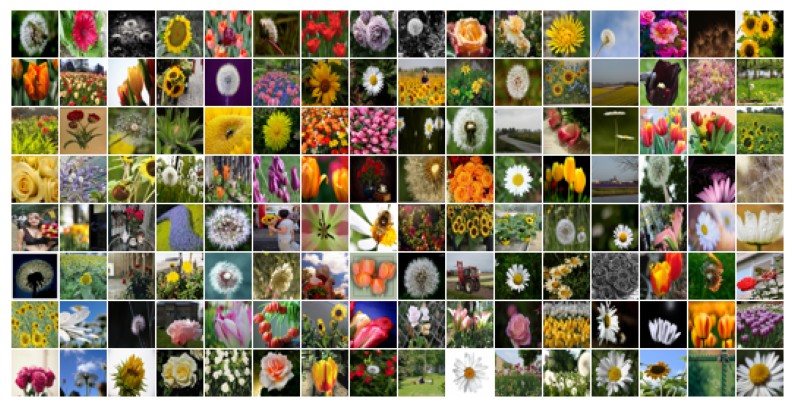

In [9]:
# Visualizing Dataset

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device="cpu"
)

plt.figure(figsize=(10, 8), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.cpu().permute(1, 2, 0))
    plt.axis("off")
    break

In [10]:
# Diffusion Class

class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device= "cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device
        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta

        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)

    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )

    # Forward Diffusion
    # Modified forward_diffusion method in SimpleDiffusion class

    """
    Performs the forward diffusion process.

    Args:
        x0: The initial input tensor (image).
        timesteps: A tensor of timesteps.

    Returns:
        A tuple containing the diffused sample and the noise added.
     """

    def forward_diffusion(self, x0: torch.Tensor, timesteps: torch.Tensor):
        eps = torch.randn_like(x0)  # Noise

        # Reshape timesteps to match batch dimensions
        batch_size = x0.shape[0]
        timesteps = timesteps.expand(batch_size)  # [B]

        # Get proper dimensions for broadcasting
        sqrt_alpha = self.sqrt_alpha_cumulative[timesteps].view(-1, 1, 1, 1)  # [B, 1, 1, 1]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumulative[timesteps].view(-1, 1, 1, 1)

        sample = sqrt_alpha * x0 + sqrt_one_minus_alpha * eps

        return sample, eps

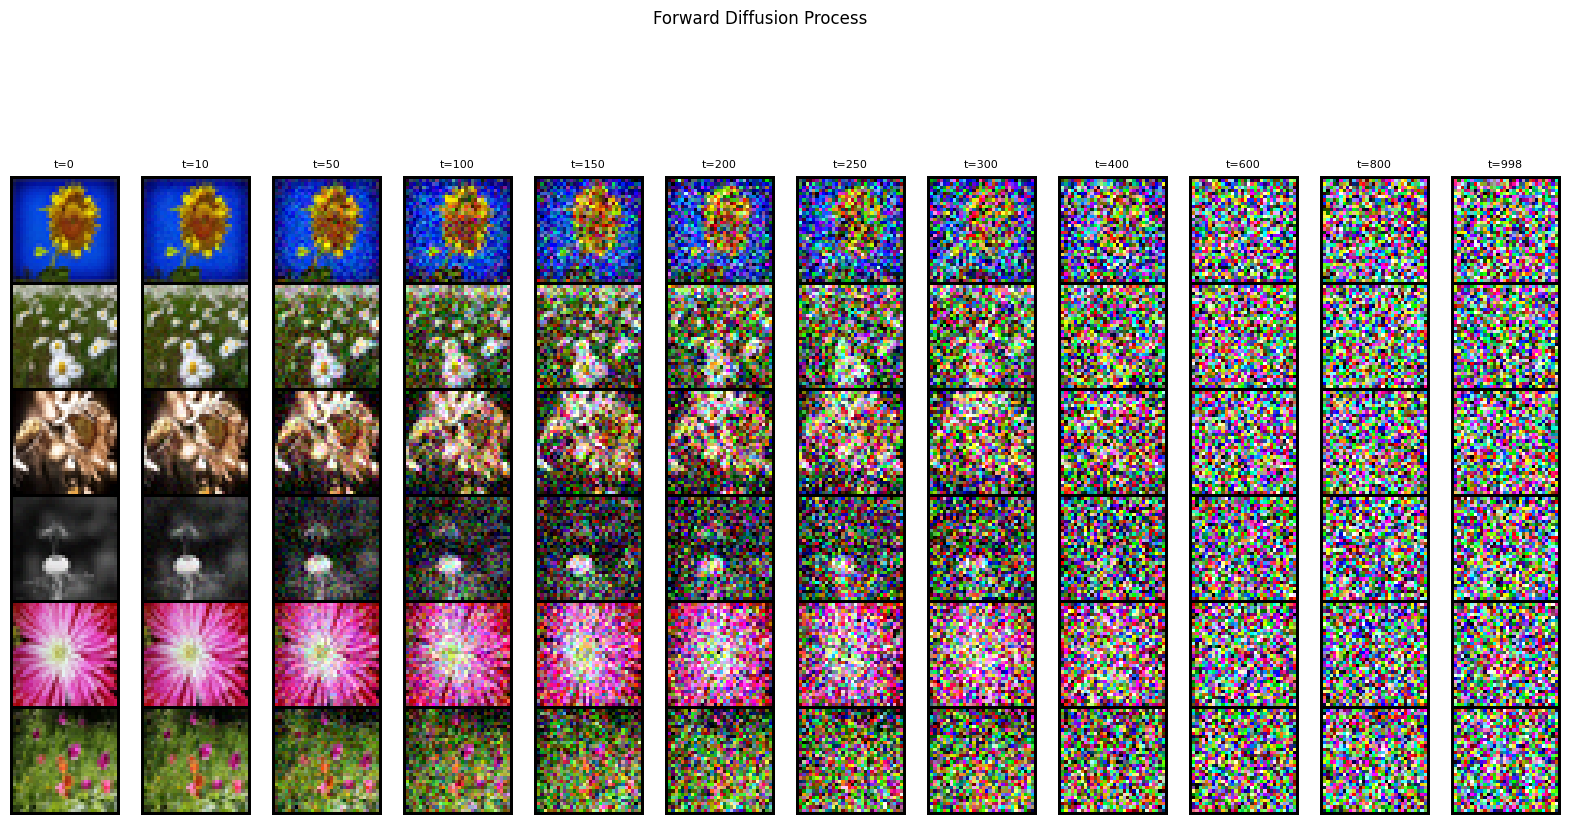

In [11]:
# Visualizing Forward Diffusion Process On Sample Images
# In this section, we’ll visualize the forward diffusion process on some sample images to see how they get corrupted as they pass through the Markov chain for T timesteps

sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu"
    )
)

# Performing the forward process for some specific timesteps and also storing the noisy versions of the original image

x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 998]
# specific_timesteps = [0, 10, 50, 99]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = sd.forward_diffusion(x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plotting sample corruption at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(20, 12), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.cpu().squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

In [12]:
# Training & Sampling Algorithms (Refer Paper)

In [13]:
!pip install -q torchmetrics

In [14]:
# Algorithm 1: Training

from torchmetrics import MeanMetric

def train_one_epoch(model, loader, sd, optimizer, scaler, loss_fn, epoch=20,
                   base_config=BaseConfig(), training_config=TrainingConfig()):

    loss_record = MeanMetric().to(base_config.DEVICE)
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")

        for x0s, _ in loader:
            tq.update(1)

            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)
            xts, gt_noise = sd.forward_diffusion(x0s, ts)

            with amp.autocast():
                pred_noise = model(xts, ts).sample
                loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value}")

        mean_loss = loss_record.compute().item()

        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss}")

    return mean_loss

In [15]:
!pip install -q Pillow

In [16]:
from PIL import Image # Import the Image class from Pillow
import numpy as np
import cv2 # Import OpenCV for video creation


def frames2vid(frames, save_path, fps=30):
    """Converts a list of frames (numpy arrays) into a video file."""

    height, width, layers = frames[0].shape
    size = (width, height)

    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for frame in frames:
        out.write(frame)
    out.release()

In [17]:
# Algorithm 2: Sampling

@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64),
                      num_images=5, nrow=8, device="cpu", **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    if kwargs.get("generate_video", False):
        outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)),
                          total=timesteps-1, dynamic_ncols=False,
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts).sample

        sd.sqrt_alpha_cumulative[ts]
        beta_t                            = sd.beta[ts]
        one_by_sqrt_alpha_t               = sd.one_by_sqrt_alpha[ts]
        sqrt_one_minus_alpha_cumulative_t = sd.sqrt_one_minus_alpha_cumulative[ts]

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        if kwargs.get("generate_video", False):
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)

    if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process.
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
        return None

    else: # Display and save the image at the final timestep of the reverse process.
        x = inverse_transform(x).type(torch.uint8)
        grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
        display(pil_image)
        return None

In [18]:
# Training DDPMs From Scratch
# In the previous sections, we have already defined all the necessary classes and functions required for training. All we have to do now is assemble them and start the training process.

# Before we begin training:

# We’ll first define all the model-related hyperparameters.
# Then initialize the UNet model,  AdamW optimizer, MSE loss function, and other necessary classes.

In [19]:
!pip install -q diffusers
!pip install -q accelerate

In [20]:
from dataclasses import dataclass
import os

import torch
import torch.nn as nn
from torch.cuda import amp
from tqdm import tqdm
import gc

from accelerate import Accelerator
from diffusers import UNet2DModel

In [21]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 256
    BASE_CH_MULT = (1, 2, 4, 4) # 32, 16, 8, 8
    APPLY_ATTENTION = (False, True, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128

model = UNet2DModel(
    in_channels             = TrainingConfig.IMG_SHAPE[0],
    out_channels            = TrainingConfig.IMG_SHAPE[0],
    # Replacing 'base_channels' with 'block_out_channels' and calculating values
    block_out_channels      = [ModelConfig.BASE_CH * i for i in ModelConfig.BASE_CH_MULT],
    layers_per_block=2,  # how many ResNet blocks to use per down/up stage
    # Removing these arguments as they are now calculated from block_out_channels
    # base_channels_multiples = ModelConfig.BASE_CH_MULT,
    # Replacing 'apply_attention' with 'down_block_types' and 'up_block_types' to control attention
    down_block_types=(
        "DownBlock2D",  # a regular ResNet block
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet block with attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet block with attention
        "UpBlock2D",  # a regular ResNet block
        "UpBlock2D",
        "UpBlock2D",
    ),
    # dropout_rate            = ModelConfig.DROPOUT_RATE,
)

model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR) # Original → Adam

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler() # For mixed-precision training.

<ipython-input-21-2f442943a4c8>:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler() # For mixed-precision training.


In [22]:
import os
from datetime import datetime

def setup_log_directory(config):
    """Sets up the log and checkpoint directories for the training run.
    Args:
        config: The configuration object containing the root log and checkpoint directories.
    Returns:
        Tuple[str, str]: The paths to the log and checkpoint directories.
    """

    # Create root directories if they don't exist.
    os.makedirs(config.root_log_dir, exist_ok=True)
    os.makedirs(config.root_checkpoint_dir, exist_ok=True)

    # Create subdirectories for the current run.
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(config.root_log_dir, config.log_dir, timestamp)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, config.checkpoint_dir, timestamp)

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    return log_dir, checkpoint_dir

In [23]:
# Initializing the logging and checkpoint directories to save intermediate sampling results and model parameters

total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())
generate_video = False
ext = ".mp4" if generate_video else ".png"

Train :: Epoch: 1/20:   1%|          | 1/135 [00:00<00:51,  2.62it/s]<ipython-input-14-e78bef423fb9>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Train :: Epoch: 1/20:  33%|███▎      | 44/135 [00:06<00:10,  8.28it/s, Loss: 1.0569355487823486]/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered `nan` values in tensor. Will be removed.
  warnings.warn(*args, **kwargs)
Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.27it/s]


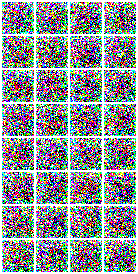

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.65it/s]


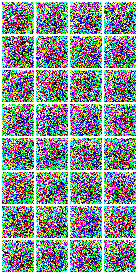

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.41it/s]


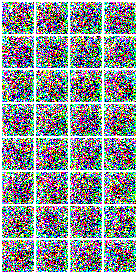

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.34it/s]


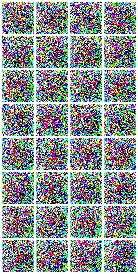

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.89it/s]


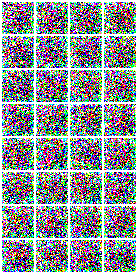

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.70it/s]


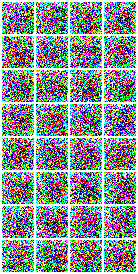

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.67it/s]


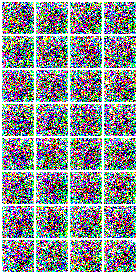

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.25it/s]


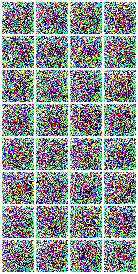

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.75it/s]


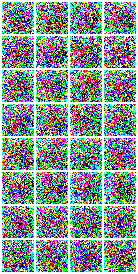

Sampling :: 100%|██████████| 999/999 [00:20<00:00, 49.02it/s]


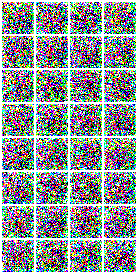

In [24]:
# Training Loop : To call the "Training" and the "Sampling" Funtions defined above

for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    # Algorithm 1: Training
    train_one_epoch(model, dataloader, sd, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 2 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")

        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS,
                          num_images=32, generate_video=generate_video, save_path=save_path,
                          img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE, nrow=4,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.pt"))
        del checkpoint_dict

In [26]:
# Generating Images Using DDPMs

model = UNet2DModel(
    in_channels             = TrainingConfig.IMG_SHAPE[0],
    out_channels            = TrainingConfig.IMG_SHAPE[0],
    block_out_channels      = [ModelConfig.BASE_CH * i for i in ModelConfig.BASE_CH_MULT],
    layers_per_block=2,
    down_block_types=(
        "DownBlock2D",  # a regular ResNet block
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet block with attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet block with attention
        "UpBlock2D",  # a regular ResNet block
        "UpBlock2D",
        "UpBlock2D",
    ),
)

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.pt"), map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"

In [30]:
log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)  # Create the directory if it doesn't exist

Sampling :: 100%|██████████| 999/999 [00:21<00:00, 47.30it/s]


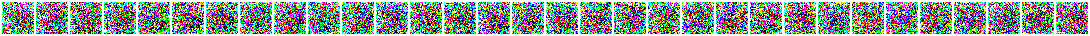

inference_results/20250402-131220.mp4


In [31]:
generate_video = True # Set it to True for generating video of the entire reverse diffusion proces or False to for saving only the final generated image.

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=32,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=32,
)

print(save_path)